In [1]:
import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay, confusion_matrix
from sklearn import metrics
from matplotlib import pyplot as plt
import plotly.express as px
import seaborn as sns

from xgboost import XGBClassifier, plot_importance

In [2]:
plt.rcParams["figure.figsize"] = (12,8)

In [3]:
df = pd.read_csv('/Users/eugeneolkhovik/python_files/ML/rec/hotels_processed.csv')

In [4]:
df.head()

,resot_hotel,is_canceled,lead_time,stays_in_weekend_nights,stays_in_week_nights,market_segment,is_repeated_guest,reserved_room_type,assigned_room_type,deposit_type,days_in_waiting_list,customer_type,adr,total_of_special_requests,Direct,GDS,TA/TO
0,1,0,13,0,1,0.247110,0,0.402264,0.451045,0,0.37372,0.418153,75.0,0,0,0,0
1,1,0,14,0,2,0.369097,0,0.402264,0.451045,0,0.37372,0.418153,98.0,1,0,0,1
2,1,0,14,0,2,0.369097,0,0.402264,0.451045,0,0.37372,0.418153,98.0,1,0,0,1
3,1,0,9,0,2,0.179125,0,0.358170,0.206119,0,0.37372,0.418153,103.0,1,1,0,0
4,1,1,85,0,3,0.369097,0,0.402264,0.451045,0,0.37372,0.418153,82.0,1,0,0,1


In [5]:
df.shape

(96935, 17)

In [43]:
x, y = df.drop('is_canceled',axis=1),df.loc[:,'is_canceled']

In [65]:
df.is_canceled.value_counts(normalize=False)

0    59916
1    37019
Name: is_canceled, dtype: int64

## Feature Importance

In [54]:
params =  {'subsample': 0.7, 'reg_lambda': 0.1, 'reg_alpha': 0.5, 'min_child_weight': 1, 'max_depth': 10, 'gamma': 2, 'colsample_bytree': 0.6}
model = XGBClassifier(**params)
model.fit(x, y)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.6,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=10, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0.5, reg_lambda=0.1, ...)

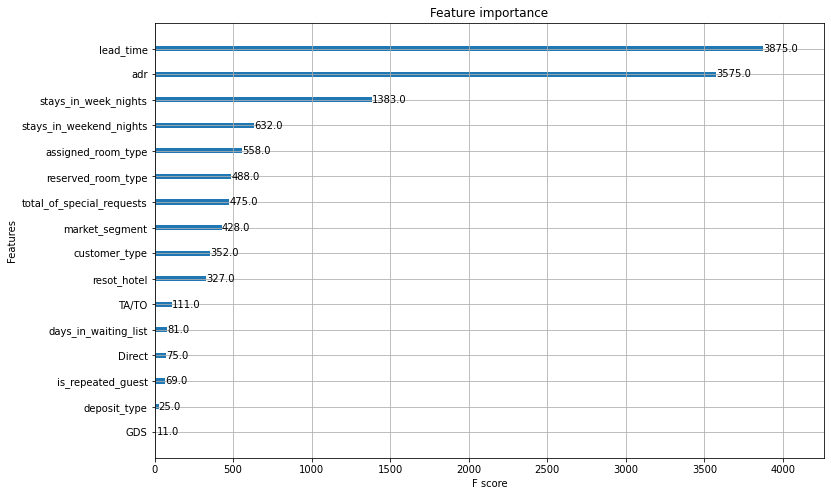

In [55]:
plot_importance(model)
plt.show()

Last 5 variables can be droped according to feature importance

In [59]:
drop_params = ['GDS', 'deposit_type', 'is_repeated_guest', 'Direct', 'days_in_waiting_list']
df.drop(columns=drop_params,inplace=True)

### Modeling



In [46]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1863)

In [67]:
# A parameter grid for XGBoost
params_xgb = {
    'max_depth': [7,9,10],
    'min_child_weight': [1, 5, 10],
    'gamma': [1.5, 2, 5],
    'subsample': [0.7,0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0.3,0.5,0.7],
    'reg_lambda': [0.1,0.3,0.5,0.7]
        }    
xgb = XGBClassifier(learning_rate=0.03, n_estimators=800,eval_metric=roc_auc_score,scale_pos_weight=1.6, objective='binary:logistic',random_state=1863)

xgb.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=<function roc_auc_score at 0x12a96b9a0>, gamma=0,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.03, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=800, n_jobs=0, num_parallel_tree=1, predictor='auto',
              random_state=1863, reg_alpha=0, reg_lambda=1, ...)

In [68]:
search_xgb = RandomizedSearchCV(xgb, params_xgb, n_iter=10, n_jobs=10 ,scoring='balanced_accuracy', cv=KFold(n_splits=5, random_state=1863, shuffle=True), verbose=2)
search_xgb.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END colsample_bytree=0.6, gamma=5, max_depth=7, min_child_weight=1, reg_alpha=0.7, reg_lambda=0.5, subsample=0.7; total time= 1.8min
[CV] END colsample_bytree=0.6, gamma=5, max_depth=7, min_child_weight=1, reg_alpha=0.7, reg_lambda=0.5, subsample=0.7; total time= 1.8min
[CV] END colsample_bytree=0.6, gamma=5, max_depth=7, min_child_weight=1, reg_alpha=0.7, reg_lambda=0.5, subsample=0.7; total time= 1.8min
[CV] END colsample_bytree=0.6, gamma=5, max_depth=7, min_child_weight=1, reg_alpha=0.7, reg_lambda=0.5, subsample=0.7; total time= 1.8min
[CV] END colsample_bytree=0.6, gamma=5, max_depth=7, min_child_weight=1, reg_alpha=0.7, reg_lambda=0.5, subsample=0.7; total time= 1.8min
[CV] END colsample_bytree=0.8, gamma=2, max_depth=7, min_child_weight=10, reg_alpha=0.3, reg_lambda=0.3, subsample=0.7; total time= 2.1min
[CV] END colsample_bytree=0.8, gamma=2, max_depth=7, min_child_weight=10, reg_alpha=0.3, reg_lambda=0.3, subsa

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=1863, shuffle=True),
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           callbacks=None, colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=<function roc_auc_score at 0x12a96b9a0>,
                                           gamma=0, gpu_id=-1,
                                           grow_policy='depthwise',
                                           importa...
                                           n_estimators=800, n_jobs=0,
                                           num_parallel_tree=1,
                                           predictor='auto', random_state=1863,
                                           reg_alpha=0, reg_lambda=1, ...),
                   n_jobs=10,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [1.5, 2, 5],
                                        'max_depth': [7, 9, 10],
                                        'min_child_weight': [1, 5, 10],
                                        'reg_alpha': [0.3, 0.5, 0.7],
                                        'reg_lambda': [0.1, 0.3, 0.5, 0.7],
                                        'subsample': [0.7, 0.8, 1.0]},
                   scoring='balanced_accuracy', verbose=2)

In [71]:
print(search_xgb.best_params_)

{'subsample': 0.7, 'reg_lambda': 0.3, 'reg_alpha': 0.3, 'min_child_weight': 5, 'max_depth': 10, 'gamma': 2, 'colsample_bytree': 0.8}


In [78]:
print(f'Training set ROC AUC score: {str(search_xgb.score(x_train, y_train))}')
print(f'Test set ROC AUC score: {str(search_xgb.score(x_test, y_test))}')

Training set ROC AUC score: 0.8616595470325483
Test set ROC AUC score: 0.8112782933509803


In [82]:
y_score = search_xgb.predict_proba(x_train)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

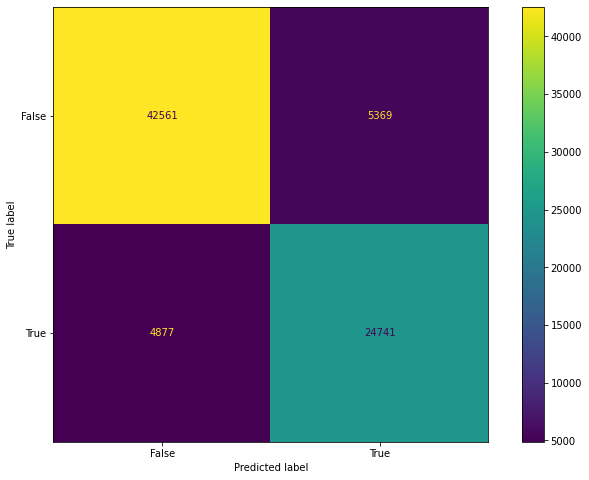

In [87]:
preds = search_xgb.predict(x_train)
preds_test = search_xgb.predict(x_test)
confusion_matrix = confusion_matrix(y_train, preds)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

In [105]:
print(f'Training set:\n    precision score: {str(metrics.precision_score(y_train, preds))}\n\
    recall score:{str(metrics.recall_score(y_train, preds))}\
       \n    f1 score:{str(metrics.f1_score(y_train, preds))} ')
print(f'Test set:\n    precision score: {str(metrics.precision_score(y_test, preds_test))}\n\
    recall score:{str(metrics.recall_score(y_test, preds_test))}\
       \n    f1 score:{str(metrics.f1_score(y_test, preds_test))} ')

Training set:
    precision score: 0.8216871471272003
    recall score:0.8353366196232022       
    f1 score:0.8284556656844362 
Test set:
    precision score: 0.7662302604939938
    recall score:0.7670585056073503       
    f1 score:0.7666441593517894 
